# Installing Dependencies

In [ ]:
!pip install energyflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.8/700.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.2/502.2 kB 39.9 MB/s eta 0:00:00


# Importing Libraries

In [ ]:
import energyflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Loading Datasets

In [ ]:
X, y = energyflow.qg_jets.load(num_data=100000)

# Checking its Shape

In [ ]:
print(X.shape)
print(y.shape)

(100000, 139, 4)
(100000,)


# Extracting Features (AI Generated)

In [ ]:
def compute_jet_features(jet_array):
    """
    Compute 4 jet-level features: Jet pT, Jet Mass, Jet Width, and Jet Multiplicity.

    Parameters:
        jet_array (numpy.ndarray): Input array of shape (100000, 139, 4),
                                   where the 4 features are [pT, rapidity, azimuthal angle, pdgid].

    Returns:
        numpy.ndarray: Output array of shape (100000, 4), where each row is [Jet_pT, Jet_Mass, Jet_Width, Jet_Multiplicity].
    """
    # Extract features
    pt = jet_array[:, :, 0]  # Transverse momentum (pT)
    rapidity = jet_array[:, :, 1]  # Rapidity (y)
    phi = jet_array[:, :, 2]  # Azimuthal angle (phi)

    # Mask for non-zero particles (to exclude padding)
    non_zero_mask = pt > 0

    # **1. Jet pT (sum of all particle pT)**
    jet_pt = np.sum(pt * non_zero_mask, axis=1)

    # **2. Jet Mass (calculated from particle 4-momenta)**
    # Calculate particle-level 4-momentum components
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(rapidity)
    e = pt * np.cosh(rapidity)

    # Sum the components for the jet
    total_px = np.sum(px * non_zero_mask, axis=1)
    total_py = np.sum(py * non_zero_mask, axis=1)
    total_pz = np.sum(pz * non_zero_mask, axis=1)
    total_e = np.sum(e * non_zero_mask, axis=1)

    # Calculate jet mass
    jet_mass = np.sqrt(np.maximum(total_e**2 - (total_px**2 + total_py**2 + total_pz**2), 0))

    # **3. Jet Width (angular spread)**
    # Compute jet axis: momentum-weighted eta and phi
    eta_jet = np.sum(pt * rapidity * non_zero_mask, axis=1) / jet_pt
    phi_jet = np.sum(pt * phi * non_zero_mask, axis=1) / jet_pt

    # Compute delta_eta and delta_phi for each particle
    delta_eta = rapidity - eta_jet[:, np.newaxis]
    delta_phi = phi - phi_jet[:, np.newaxis]
    delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # Wrap to [-pi, pi]

    # Compute angular distance (delta_R)
    delta_r = np.sqrt(delta_eta**2 + delta_phi**2)

    # Compute jet width (momentum-weighted angular spread)
    jet_width = np.sum(pt * delta_r * non_zero_mask, axis=1) / jet_pt

    # **4. Jet Multiplicity (total number of particles in the jet)**
    jet_multiplicity = np.sum(non_zero_mask, axis=1)

    # Combine results into (100000, 4) array
    jet_features = np.stack([jet_pt, jet_mass, jet_width, jet_multiplicity], axis=1)
    return jet_features

# Example usage
# Assume `jets` is your (100000, 139, 4) array
# jets = np.load("your_dataset.npy")
jet_features = compute_jet_features(X)
print(jet_features.shape)  # Should print (100000, 4)

(100000, 4)


1. Jet_pT - Sum of all pT's in a jet


2. Jet_Mass -

      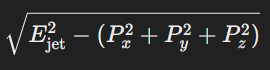

      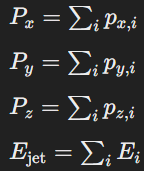

      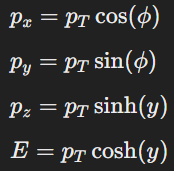





3. Jet_Width -

      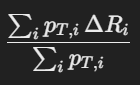

      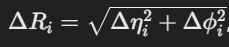

      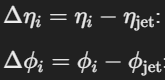

      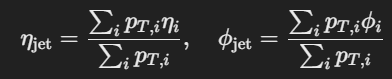





4. Jet_Multiplicity - Number of Particles in Jet

**I researched the physics of these jets on google and found these characteristics to be the most useful for determining the existence of quarks/gluons.**

# Creating Logistic Regression Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(jet_features, y, test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy} %')
print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report: ")
print(classification_report(y_test, y_pred))

Accuracy: 77.33%

Confusion Matrix:
[[7502 2387]
 [2148 7963]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77      9889
         1.0       0.77      0.79      0.78     10111

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

